## 1. Постановка задачи

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

Произведём сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определим оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [223]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


У нас есть данные о более чем полумиллионе транзакций. Признаки:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.


Посмотрим на пропуски

In [224]:
data_null = pd.DataFrame(data.isnull().sum(), columns=['Number of null'])
data_null['percentage'] = (data.isnull().sum() / len(data) * 100 )
data_null

,Number of null,percentage
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.268311
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135080,24.926694
Country,0,0.000000


Проверим за какой период у нас предоставлены данные


In [225]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')

print(data['InvoiceDate'].min(), 'to', data['InvoiceDate'].max())

2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [226]:
display(data['Quantity'].min())
display(data['Quantity'].max())

display(data[data['UnitPrice'] >= 0]['UnitPrice'].min())

-80995

80995

0.0

Как видим, есть две транзакции, в одной из которых указано более 80 тысяч единиц товара, а в другой — отрицательное количество товаров (вероятно, это свидетельствует об отмене транзакции). Чтобы понять природу таких транзакций, нам нужно исследовать их более детально.

Также видим, что есть товары, которые «отдаются даром» — они тоже нуждаются в дополнительной проверке.

In [227]:
round(data.describe(include='all'))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.0,541909,541909.0,406829,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983,495478
mean,NaN,NaN,NaN,10.0,2011-07-04 13:34:57.156386048,5.0,NaN,NaN
min,NaN,NaN,NaN,-80995.0,2010-12-01 08:26:00,-11062.0,NaN,NaN
25%,NaN,NaN,NaN,1.0,2011-03-28 11:34:00,1.0,NaN,NaN
50%,NaN,NaN,NaN,3.0,2011-07-19 17:17:00,2.0,NaN,NaN
75%,NaN,NaN,NaN,10.0,2011-10-19 11:27:00,4.0,NaN,NaN
max,NaN,NaN,NaN,80995.0,2011-12-09 12:50:00,38970.0,NaN,NaN


## 3. Предобработка и очистка данных

Удалим строки, содержащие пропуски

In [228]:
data = data.dropna(axis=0)
data.shape[0]

406829

In [229]:
dupl_columns = list(data.columns)


mask = data.duplicated(subset=dupl_columns)
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')


data = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {data.shape[0]}')

Число найденных дубликатов: 5225
Результирующее число записей: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [230]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Не похоже на какую-то ошибку или выбросы, случаев слишком много.

При просмотре таблицы можно заметить следующее:
- "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
- Код товара может содержать различные специальные символы: например, символ "D" - Discount
- Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [231]:
print(f"Все номера заказов в таблице negative_quantity - возвратные: {negative_quantity.shape[0] == negative_quantity['InvoiceNo'].str.contains('C').count()}")

Все номера заказов в таблице negative_quantity - возвратные: True


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [232]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак (order_canceled): 1, если возврат, и 0 — в противном случае.

In [233]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)
round(nb_products_per_basket['order_canceled'].value_counts()[1] / nb_products_per_basket.shape[0] *100)

16

взглянем на отменённые заказы:

In [234]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [235]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Вот пример пары «заказ-отмена».

Возможно для каждой отменённой транзакции в базе данных (таблица data) существует её аналог

In [236]:
returns = negative_quantity.copy()
returns.reset_index(inplace=True)
returns['Quantity'] = -returns['Quantity']
matched = pd.merge(returns, data,
                   on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Количество несовпадений: {negative_quantity.shape[0] - matched.shape[0]}')

Количество несовпадений: 5626


In [237]:
'''for index, col in negative_quantity.iterrows():
    if data[(data['CustomerID']==col['CustomerID'])&(data['Quantity']==-col['Quantity'])&\
        (data['StockCode']==col['StockCode'])].shape[0]==0:
        print(col)
        break'''

"for index, col in negative_quantity.iterrows():\n    if data[(data['CustomerID']==col['CustomerID'])&(data['Quantity']==-col['Quantity'])&        (data['StockCode']==col['StockCode'])].shape[0]==0:\n        print(col)\n        break"

Код товара может содержать различные специальные символы: например, символ "D" - Discount. Посмотрим на клиента с идентификатором 14527:

In [238]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Первая строка - заказ C536379 — противоположных ему аналогов по количеству товаров - нет. По-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это.

Возможно для каждой отменённой транзакции в базе данных (data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

In [239]:
negative_quantity_noD = negative_quantity[negative_quantity['StockCode'] != 'D']
for index, col in negative_quantity_noD.iterrows():
    if data[(data['CustomerID']==col['CustomerID'])&(data['Quantity']==-col['Quantity'])&\
        (data['Description']==col['Description'])].shape[0]==0:
        print(col)
        break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
Name: 154, dtype: object


Посмотрим, где кроется наша проблема. Посмотрим транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [240]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


Так же удалим транзакции, в поле которых указано отрицательное количество товара.  

In [241]:
'''def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for col in negative_quantity.itertuples():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col.CustomerID) &
                       (data['StockCode']  == col.StockCode) & 
                       (data['InvoiceDate'] < col.InvoiceDate) & 
                       ((quantity_canceled.loc[col.Index] - col.Quantity) <= data['Quantity'])].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет одного и более контрагентов
        # Добавляем количество отмененного в столбец QuantityCanceled 
        else:
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = quantity_canceled.loc[index_order] - col.Quantity       
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)'''

"def get_quantity_canceled(data):\n    # Инициализируем Series той же длины, что и столбцы таблицы, нулями\n    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    \n    negative_quantity = data[(data['Quantity'] < 0)].copy()\n    for col in negative_quantity.itertuples():\n        # Создаем DataFrame из всех контрагентов\n        df_test = data[(data['CustomerID'] == col.CustomerID) &\n                       (data['StockCode']  == col.StockCode) & \n                       (data['InvoiceDate'] < col.InvoiceDate) & \n                       ((quantity_canceled.loc[col.Index] - col.Quantity) <= data['Quantity'])].copy()\n        # Транзация-возврат не имеет контрагента - ничего не делаем\n        if (df_test.shape[0] == 0): \n            continue\n        # Транзакция-возврат имеет одного и более контрагентов\n        # Добавляем количество отмененного в столбец QuantityCanceled \n        else:\n            df_test.sort_index(axis=0 ,ascending=False, inplace = True

In [242]:
# cоздаем датафрейм только из продаж
data_sales = data[(data['Quantity'] > 0)].reset_index()
# cоздаем датафрейм только из возвратов и убираем ненужные колонки
data_returns = data[(data['Quantity'] < 0)].reset_index().drop(['Description', 'Country', 'InvoiceNo', 'UnitPrice'], axis=1)
# объединяем созданные датафреймы в один, в котором будут только покупки с возвратами
data_merged = data_sales.merge(data_returns, how = 'inner',on = ['StockCode','CustomerID'])
# оставляем в объединенном датафрейме только те данные, где покупки были ранее возвратов 
data_merged = data_merged[(data_merged['InvoiceDate_x'] < data_merged['InvoiceDate_y'])]
# мы получили фрейм с несколькими вариантами соответствий транзакций-возвратов транзакциям-покупок,
# далее нам нужно оставить по одному соответствию каждому возврату (это должна быть ближайшая покупка к каждому возврату)

# на этом этапе, чтобы попасть в логику предоставленной студентам функции get_quantity_canceled(), и соответственно, получить 
# идентичный датафрейм, мне приходится найти дубликаты индексов возвратов (то есть для тех транзакций-возвратов, 
# которые имеет несколько противоположных транзакций) и удалить те, в которых количество товаров возврата больше покупки
# (для транзакций-возвратов, имеющих только одну противоположную транзакцию, функцией-образцом такой опции не предусмотрено,
# поэтому я также этого не делаю)
duplicate_list = list(set(data_merged[data_merged.duplicated(['index_y'])]['index_y']))
data_merged['dup'] = 0
data_merged.loc[data_merged['index_y'].isin(duplicate_list), 'dup'] = 1
data_merged = data_merged[(data_merged['Quantity_x'] >= (- data_merged['Quantity_y'])) | (data_merged['dup'] == 0)]

# группируем полученный фрейм по индексам возвратов и находим для каждого такого индекса максимальное значение индекса транзакции-покупки 
# (это как раз будет ближайшая покупка к возврату) 
data_group = data_merged.groupby(['index_y']).agg({'index_x': ['max'] }).reset_index()
data_group.columns = ['index_y', 'index_x']
# группируем полученный фрейм по индексам покупок и находим для каждого такого индекса максимальное значение индекса транзакции-возврата
# (это как раз будет ближайший возврат к покупке)
data_group_2 = data_group.groupby(['index_x',]).agg( {'index_y': ['max'] }).reset_index()
data_group_2.columns = ['index_x', 'index_y']
# в этом фрейме мы получили все уникальные индексы возвратов с соответсвующими им уникальными индексами покупок

# теперь нам нужно количество в каждой найденной нами транзакции-возврате, для этого объединяем полученный фрейм
# с датафреймом, состоящим из возвратов
data_returns_merged = data_returns.merge(data_group_2, how = 'inner',left_on = 'index',right_on = 'index_y')
# убираем ненужные колонки
data_returns_merged.drop (data_returns_merged.columns [[0,1,3,4]], axis = 1 , inplace = True )
# и теперь осталось получить результирующий датафрейм 
# объединяем фрейм  покупок с фреймом возвратов
data_merged_2 = data_sales.merge(data_returns_merged, how = 'left', left_on = 'index', right_on = 'index_x')
# сменим знак в количестве возвратов на положительный и заполним нулями невостребованные для возвратов транзакции-покупок
data_merged_2['Quantity_y'] = (-data_merged_2['Quantity_y']). fillna (0)
# причешем полученный датафрейм для получения необходимого нам результирующего фрейма:
data_merged_2.drop (data_merged_2.columns [[0,10,11]], axis= 1 , inplace= True )
data_merged_2.rename(columns = {'Quantity_x':'Quantity', 'Quantity_y':'QuantityCanceled'}, inplace = True )
data_merged_2
# и кстати, здесь мы решаем сразу задание 3.8 :)
data = data_merged_2

Следующая проблема — это специальные виды транзакций. Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы. 

In [243]:
data = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True) == False]
data.shape

(391183, 9)

На некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций менее 1 %, поэтому от них можно просто избавиться.

In [244]:
data = data[data['UnitPrice'] != 0]
data.shape

(391150, 9)

## 4. Разведывательный анализ данных

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Выясним, в каких странах живут клиенты. 

Уберем из визуализации Великобританию, тк там проживает абсолютное большинство клиентов и высокое значение будет мешать визуализации

In [245]:
country_df = data.groupby('Country').agg(Customers=('CustomerID', 'nunique')).reset_index()
country_df.columns = ['Country', 'Customers']

filtered_country_df = country_df[country_df['Country'] != 'United Kingdom']
fig = px.choropleth(filtered_country_df, locations='Country', locationmode='country names', color='Customers', scope='world')
fig.show()
country_df.sort_values('Customers', ascending=False)[:6]

,Country,Customers
35,United Kingdom,3916
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25
32,Switzerland,21


Посмотрим на распределение заказов в разрезе стран.

Уберем из визуализации Великобританию, тк там происходит абсолютное большинство заказов и высокое значение будет мешать визуализации

In [246]:
country_df = data.groupby('Country').agg(Customers=('InvoiceNo', 'nunique')).reset_index()
country_df.columns = ['Country', 'Invoices']

filtered_country_df = country_df[country_df['Country'] != 'United Kingdom']
fig = px.choropleth(filtered_country_df, locations='Country', locationmode='country names', color='Invoices', scope='world')
fig.show()
country_df.sort_values('Invoices', ascending=False)[:6]

,Country,Invoices
35,United Kingdom,16579
14,Germany,443
13,France,379
10,EIRE,256
3,Belgium,98
23,Netherlands,93


Добавим в датасет общую цену заказа
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [247]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

Постройте визуализацию по странам, клиенты из которых приносят компании больше всего выручки

Уберем из визуализации Великобританию

In [248]:
country_df = data.groupby('Country').agg(Customers=('TotalPrice', 'sum')).reset_index()
country_df.columns = ['Country', 'TotalPrice']

filtered_country_df = country_df[country_df['Country'] != 'United Kingdom']
fig = px.choropleth(filtered_country_df, locations='Country', locationmode='country names', color='TotalPrice', scope='world')
fig.show()

In [249]:
country_df.sort_values('TotalPrice', ascending=False)[:6]

,Country,TotalPrice
35,United Kingdom,6797691.44
23,Netherlands,283443.54
10,EIRE,247074.57
14,Germany,201520.71
13,France,181529.63
0,Australia,136950.25


Теперь займёмся временными характеристиками.


Добавим признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам.

In [250]:
def add_datetime_features(df):
    df['Invoice_month'] = df['InvoiceDate'].dt.month
    df['Invoice_dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['Invoice_hour'] = df['InvoiceDate'].dt.hour
    return df

data = add_datetime_features(data)

Text(0.5, 1.0, 'Sum income per Month of year')

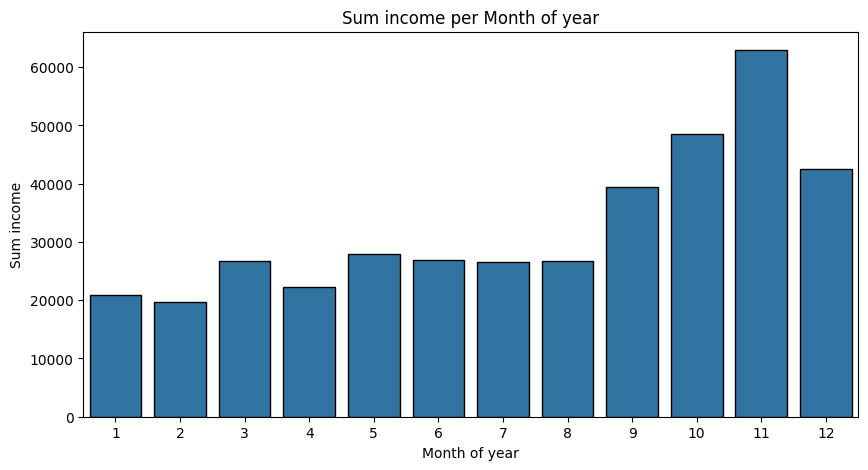

In [251]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data, x='Invoice_month')
ax.set_xlabel('Month of year')
ax.set_ylabel('Sum income')
plt.title('Sum income per Month of year')

Самый прибыльный месяц - ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Посмотри на количество заказов для каждого дня недели.

Text(0.5, 1.0, 'Invoice count per Day of week')

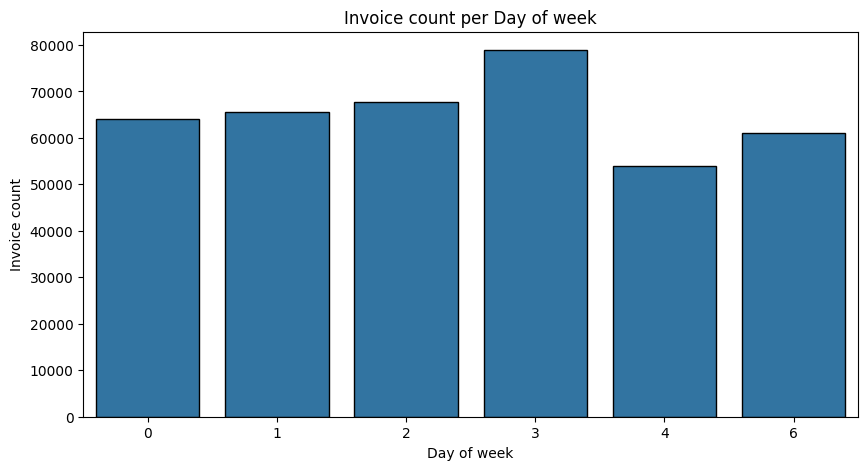

In [252]:
agg_func = {'InvoiceNo':['count']}
data_day = data.groupby(['Invoice_dayofweek']).agg(agg_func)
fig = plt.figure(figsize=(10, 5))
barplot = sns.barplot(data=data_day, 
                    x= data_day.index,
                    y= data_day[('InvoiceNo', 'count')],
                    orient='v'
)
barplot.set_xlabel('Day of week')
barplot.set_ylabel('Invoice count')
barplot.set_title('Invoice count per Day of week')

Cогласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

Найдём среднее количество ежедневно поступающих заказов в каждый из часов.

In [253]:
# Группировка данных по дате и часу совершения транзакции
orders_per_hour = data.groupby(['InvoiceDate', 'Invoice_hour']).size().reset_index(name='Orders')

# Нахождение среднего количества ежедневно поступающих заказов в каждый час
mean_orders_per_hour = orders_per_hour.groupby('Invoice_hour')['Orders'].mean().reset_index(name='Mean_Orders')

# Построение визуализации
fig = px.line(mean_orders_per_hour, x='Invoice_hour', y='Mean_Orders', title='Среднее количество ежедневно поступающих заказов по времени суток', labels={'Invoice_hour': 'Hour of the day', 'Mean_Orders': 'Mean Orders'})
fig.show()

Больше всего заказов совершается в дневное время и в 20 часов перед закрытием

С 21 часа до 6 утра (не включительно) заказы не поступают.

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* **Recency** для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* **Frequency** рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* **Monetary Value** рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [254]:
now = pd.to_datetime('2011-12-10')
custom_aggregation = {
    'InvoiceDate':  lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: len(x.unique()),
    'TotalPrice': lambda x: x.sum(),
}

rfm_table = data.groupby('CustomerID').agg(custom_aggregation)

rfm_table = rfm_table.rename(
    columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary', 'TotalQuantity': 'MeanQuantity'}
)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [255]:
#Необходимо, чтобы CustomerID являлся индексом в таблице rfm_table.

boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра **Frequency** или параметра **Monetary** выше, чем у 95 % клиентов.


Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 


In [256]:
def outliers_iqr(data, feature1, feature2):
    x1 = data[feature1]
    x2 = data[feature2]
    quartile_1, quartile_2 = x1.quantile(0.95), x2.quantile(0.95),
    cleaned = data[((x1 <= quartile_1) & (x2 <= quartile_2))]
    return cleaned

rfm_table_cleaned = outliers_iqr(rfm_table, 'Frequency', 'Monetary')

In [257]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Перед кластеризацией нам необходимо оценить, как распределены наблюдения в пространстве признаков. У нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния.


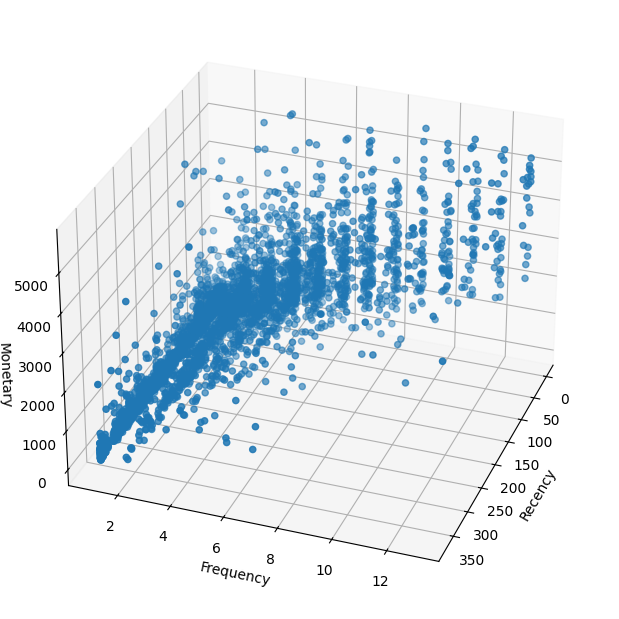

In [258]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Используем методы снижения размерности.

### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [259]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)

rfm_table_processed = pd.DataFrame(
    rfm_table_processed,
    columns = ['axis-1', 'axis-2']
)

print('Первая главная компонента объясняет {:.2f} долю дисперсии исходных данных.'
      .format(pipeline['PCA'].explained_variance_ratio_[0]))

Первая главная компонента объясняет 0.68 долю дисперсии исходных данных.


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

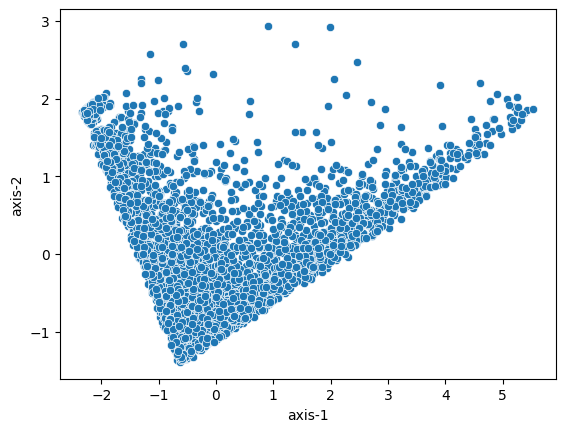

In [260]:
sns.scatterplot(data = rfm_table_processed, x = 'axis-1', y = 'axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

Судя по форме пространства, мы можем с уверенностью сказать, что нам не подойдут алгоритмы, основанные на плотности, такие как DBSCAN, так как точки расположены очень близко друг к другу и большая часть точек будет определена в единый кластер, что не имеет смысла.

Воспользуемся методом k-means. 

In [261]:
# создаём пустой список для сохранения результатов
silhouette = []

# проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(2, 11):
    # обучаем модель k-means с текущим количеством кластеров
    km = cluster.KMeans(
        n_clusters = i,
        random_state = 42
    ).fit(rfm_table_processed)
    # добавляем коэффициент силуэта в список для результатов
    silhouette.append(metrics.silhouette_score(rfm_table_processed, km.labels_))

# выводим лучший результат
print('Количество кластеров:', silhouette.index(np.array(silhouette).max()) + 2)
print('Коэффициент силуэта:', round(np.array(silhouette).max(), 2))

Количество кластеров: 3
Коэффициент силуэта: 0.52


Подберём оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта.


In [262]:
# создаём пустой список для сохранения результатов
silhouette = []

# проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(2, 11):
    # обучаем EM-алгоритм с текущим количеством кластеров
    gm = mixture.GaussianMixture(
        n_components = i,
        random_state = 42
    ).fit_predict(rfm_table_processed)
    # добавляем коэффициент силуэта в список для результатов
    silhouette.append(metrics.silhouette_score(rfm_table_processed, gm))

# выводим лучший результат
print('Количество кластеров:', silhouette.index(np.array(silhouette).max()) + 2)
print('Коэффициент силуэта:', round(np.array(silhouette).max(), 2))

Количество кластеров: 3
Коэффициент силуэта: 0.44


Посмотрим на распределение кластеров.

In [263]:
# обучаем модель k-means с оптимальным количеством кластеров
km = cluster.KMeans(n_clusters = 3, random_state = 42)
km.fit(rfm_table_processed)

# добавляем значения кластеров
rfm_table_processed['labels'] = km.labels_
rfm_table_processed['labels'].value_counts()

labels
2    2270
1    1001
0     773
Name: count, dtype: int64

Визуализируем результаты кластеризации:

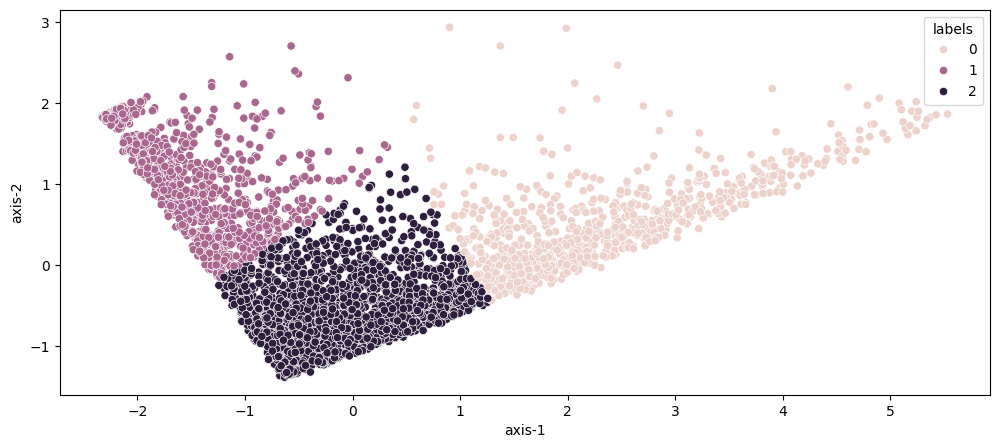

In [264]:
fig = plt.figure(figsize = (12, 5))
sns.scatterplot(
    data = rfm_table_processed,
    x = 'axis-1',
    y = 'axis-2',
    hue = 'labels'
);

Попробуем составить профиль для трёх сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов. Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [265]:
# добавляем значения кластеров к RFM-таблице, очищенной от выбросов
rfm_table_cleaned['Labels'] = km.labels_

# группируем RFM-таблицу и рассчитываем среднее
grouped_rfm = rfm_table_cleaned.groupby('Labels').mean()
round(grouped_rfm)

,Recency,Frequency,Monetary
Labels,,,
0,32.0,7.0,2662.0
1,253.0,1.0,387.0
2,51.0,2.0,661.0


В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [266]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

In [267]:
plot_cluster_profile(grouped_rfm, 3)

**0 Кластер** соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

**2 Кластер** соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».

**1 Кластер** соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому модифицируем полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

Попробуем использовать нелинейную трансформацию.

Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

**Примечание:**
Дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.

In [268]:
# удаляем из RFM-таблицы метки кластеров, чтобы не было утечки данных
rfm_table_cleaned.drop('Labels', axis = 1, inplace = True)

# создаём pipeline
pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        (
            'tsne',
            manifold.TSNE(n_components = 2, perplexity = 50, random_state = 100)
        )
    ]
)

# обучаем pipeline и применяем к очищенной RFM-таблицу
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(
    rfm_table_processed,
    columns = ['axis-1', 'axis-2']
)
print(
    'Знчение дивергенции Кульбака-Лейблера:',
    np.round(pipeline['tsne'].kl_divergence_, 2)
)

Знчение дивергенции Кульбака-Лейблера: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


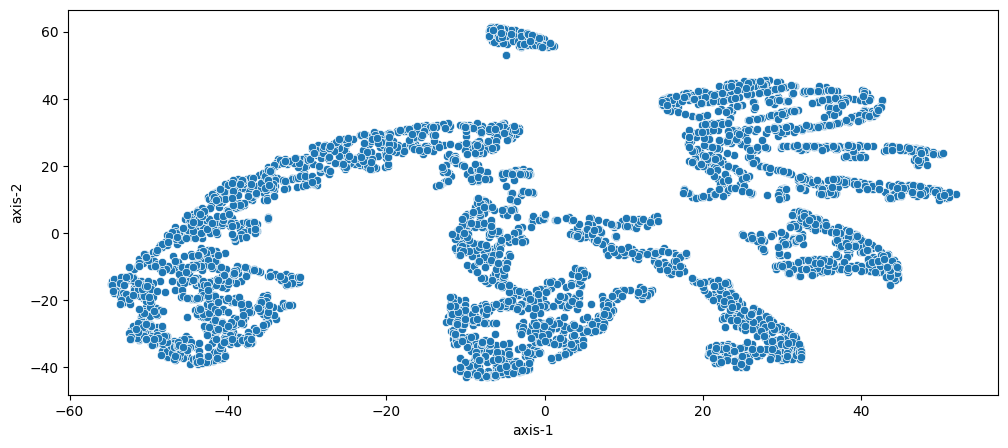

In [269]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


In [270]:
# создаём пустой список для сохранения результатов
silhouette = []

# проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(3, 9):
    # обучаем модель k-means с текущим количеством кластеров
    km = cluster.KMeans(
        n_clusters = i,
        random_state = 42
    ).fit(rfm_table_processed)
    # добавляем коэффициент силуэта в список для результатов
    silhouette.append(metrics.silhouette_score(rfm_table_processed, km.labels_))

# выводим лучший результат
print('Количество кластеров:', silhouette.index(np.array(silhouette).max()) + 3)
print('Коэффициент силуэта:', round(np.array(silhouette).max(), 2))

Количество кластеров: 8
Коэффициент силуэта: 0.48


Попробуем воспользоваться EM-алгоритом.

In [271]:
# создаём пустой список для сохранения результатов
silhouette = []

# проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(3, 9):
    # обучаем EM-алгоритм с текущим количеством кластеров
    gm = mixture.GaussianMixture(
        n_components = i,
        random_state = 42
    ).fit_predict(rfm_table_processed)
    # добавляем коэффициент силуэта в список для результатов
    silhouette.append(metrics.silhouette_score(rfm_table_processed, gm))

# выводим лучший результат
print('Количество кластеров:', silhouette.index(np.array(silhouette).max()) + 3)
print('Коэффициент силуэта:', round(np.array(silhouette).max(), 2))

Количество кластеров: 4
Коэффициент силуэта: 0.47


Воспользуемся алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

In [272]:
# создаём пустой список для сохранения результатов
silhouette = []

# проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(3, 9):
    # обучаем алгоритм агломеративной кластеризации
    ag = cluster.AgglomerativeClustering(n_clusters = i).fit(
        rfm_table_processed
    )
    # добавляем коэффициент силуэта в список для результатов
    silhouette.append(metrics.silhouette_score(rfm_table_processed, ag.labels_))

# выводим лучший результат
print('Количество кластеров:', silhouette.index(np.array(silhouette).max()) + 3)
print('Коэффициент силуэта:', round(np.array(silhouette).max(), 2))

Количество кластеров: 8
Коэффициент силуэта: 0.48


Давайте посмотрим на распределение кластеров.

In [273]:
# обучаем алгоритм агломеративной кластеризации с оптимальным количеством кластеров
ag = cluster.AgglomerativeClustering(n_clusters = 8)
ag.fit(rfm_table_processed)

# добавляем значения кластеров
rfm_table_processed['labels'] = ag.labels_
rfm_table_processed['labels'].value_counts()

labels
1    903
2    647
0    633
5    570
3    503
4    409
6    265
7    114
Name: count, dtype: int64

Визуализируем результаты кластеризации:

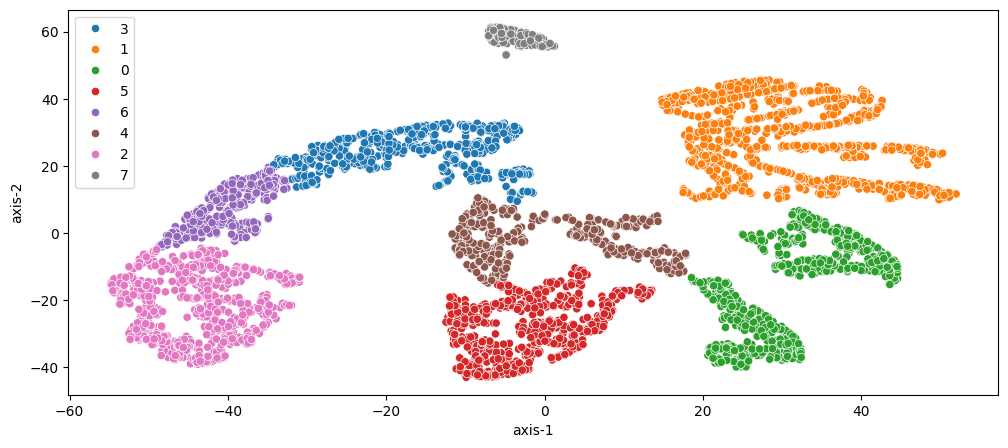

In [274]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=ag.labels_.astype('str'));

Итак, у нас есть 8 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам.

In [275]:
# добавляем значения кластеров к RFM-таблице, очищенной от выбросов
rfm_table_cleaned['Labels'] = ag.labels_

# группируем RFM-таблицу и рассчитываем среднее
grouped_rfm = rfm_table_cleaned.groupby('Labels').mean()
round(grouped_rfm)

,Recency,Frequency,Monetary
Labels,,,
0,36.0,4.0,973.0
1,33.0,7.0,2420.0
2,46.0,1.0,324.0
3,274.0,1.0,353.0
4,168.0,3.0,665.0
5,42.0,2.0,681.0
6,151.0,1.0,266.0
7,365.0,1.0,236.0


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [276]:
plot_cluster_profile(grouped_rfm, 8)

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов. Теперь нужно сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку.

Мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

Разделим исходные данные на тренировочную и тестовую выборки.

In [281]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned.drop(['Labels'], axis = 1) #очищенная RFM-таблица
y = rfm_table_cleaned['Labels'] #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 

Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому сразу используем ансамблевые алгоритмы. 

Начнём со случайного леса.

В качестве метрики используем accuracy.

In [282]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}


grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state= 42),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1
)
%time grid_search_rf.fit(X_train, y_train)

y_train_pred = grid_search_rf.predict(X_train)
y_test_pred = grid_search_rf.predict(X_test)

print('accuracy_score на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

CPU times: total: 1.19 s
Wall time: 19.6 s
accuracy_score на тестовом наборе: 0.986
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 200}


Итак, значение метрики accuracy очень высокое, но не идеальное. Попробуем его улучшить, воспользовавшись бустингом.

С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier)

In [283]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
grid_search_gbm = GridSearchCV(
    estimator = GradientBoostingClassifier(random_state= 42),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    scoring = 'accuracy'
)
%time grid_search_gbm.fit(X_train, y_train)

y_train_pred = grid_search_gbm.predict(X_train)
y_test_pred = grid_search_gbm.predict(X_test)

print('accuracy_score  на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_gbm.best_params_))

CPU times: total: 4.97 s
Wall time: 2min 6s
accuracy_score  на тестовом наборе: 0.986
Наилучшие значения гиперпараметров: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


Справились с проблемой непараметричности t-SNE и перешли от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

В заключение отметим, что сегментация клиентов не ограничивается только RFM-анализом. Что ещё можно сделать?

- Выделить оптовиков в отдельный сегмент. В таком случае идея метода RFM расширяется путём добавления в датасет информации о среднем количестве покупаемого товара за один заказ. То есть аббревиатура RFM превращается в RFMQ, где Q — среднее количество товаров в одном заказе.
- Произвести кластерный анализ товаров на основе их описания и сформировать категории, по которым совершаются покупки.
- Рассчитать частоту покупки каждой категории товаров для каждого клиента. Эта информация может стать основой для построения модели кластеризации и сегментирования клиентов по их интересам.
- Наконец, воспользоваться информацией о сезонности покупок и добавить в модель информацию о частоте покупок клиентов в каждый из месяцев. Так можно определить, какие клиенты являются постоянными, то есть их покупки не зависят от сезона, а какие покупают товары только в преддверии праздников. Эта информация позволит экспериментировать с маркетинговой кампанией и повышать лояльность клиентов.